In [ ]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 08:49:21--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [   <=>              ]  19.68M  44.2MB/s    in 0.4s    

2025-06-13 08:49:22 (44.2 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [ ]:
pip install Groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re

In [ ]:
Groq_api_key = 'api_key'
client =Groq(api_key=Groq_api_key)

In [ ]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [ ]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""You are a python expert and you are given a dataset which is preprocessed using below code:

    df = pd.read_csv('household_power_consumption.txt',
                     sep=';',
                     parse_dates={{'datetime': ['Date', 'Time']}},
                     infer_datetime_format=True,
                     na_values='?',
                     low_memory=False)

    df = df.dropna(inplace=True)
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')

    and following are the column names in the dataset after preprocessing where as you can see that the index is set to datetime:
    {df_info_str}


    Provide me with only python pandas code for below natural language questions no theory, explanation is needed. Please only provide the pandas code with necessary imports which should print the result when executed:
    {natural_language_question}

    """

    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [ ]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}

    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec(fixed_code, {'df': df}) #execute the code in the context of the dataframe
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [ ]:
df = load_data_set()

<ipython-input-6-2730963339>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-6-2730963339>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-6-2730963339>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


In [ ]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [ ]:
print(df.columns.tolist())

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


# consider for Analysis

In [ ]:
#mistra-saba-24b Model Testing

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2008","mistral-saba-24b",df)

------------------------------------------------------------------------
Python pandas Code is:

 df.loc['2008-02-01':'2008-02-07', 'Voltage'].groupby(df['DayOfWeek']).mean()
------------------------------------------------------------------------
Output of the code is:



In [ ]:
execute_query("What was the average active power consumption in March 2007?","mistral-saba-24b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Assuming df is already loaded and preprocessed as described
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter the data for March 2007
march_2007_data = df[df.index.month == 3 & df.index.year == 2007]
# Calculate the average active power consumption in March 2007
average_active_power_march_2007 = march_2007_data['Global_active_power'].mean()
print(average_active_power_march_2007)
------------------------------------------------------------------------
Output of the code is:

Error executing code: The truth value of an array with more than one eleme

False

In [ ]:
execute_query("What hour of the day had the highest power usage on Christmas 2006?","mistral-saba-24b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Assuming the DataFrame is already loaded as 'df'
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for Christmas 2006
christmas_2006 = df[df.index.year == 2006]
# Group by hour and sum the power usage
hourly_power = christmas_2006.groupby(christmas_2006.index.hour)['Global_active_power'].sum()
# Find the hour with the highest power usage
max_hour = hourly_power.idxmax()
max_power = hourly_power.max()
print(f"The hour with the highest power usage on Christmas 2006 was {max_hour} with a usage of {max_power} kW.")
-------------------------------

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Assuming df is already preprocessed as described
df['weekday'] = df.index.weekday
# Group by weekday and calculate mean Global_active_power
weekday_usage = df.groupby('weekday')['Global_active_power'].mean()
# Plot the results
weekday_usage.plot(kind='bar')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
------------------------------------------------------------------------
Output of the code is:



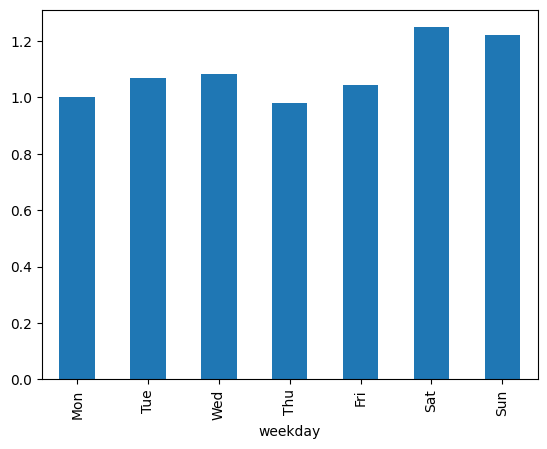

In [ ]:
execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends. Can you show it using visualizatio tool","mistral-saba-24b",df)

In [ ]:
execute_query("Find days where total energy consumption exceeded 5 kWh.","mistral-saba-24b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Assuming df is already loaded and preprocessed as described
# df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['?'], low_memory=False)
# df = df.dropna()
# df['Global_active_power'] = df['Global_active_power'].astype(float)
# df = df.set_index('datetime')
# Calculate daily consumption
df['daily_consumption'] = df['Global_active_power'].resample('D').sum()
# Find days where total energy consumption exceeded 5 kWh
exceeded_days = df[df['daily_consumption'] > 5]
# Print the result
print(exceeded_days[['daily_consumption']])
------------------------------------------------------------------------
Output of the code is:

            daily_consumption
datetime                     
2006-12-17           3390.460
2006-12-18           2203.826
2006-12-19           1666.194
2006-12-20 

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Assuming df is already loaded and preprocessed as described
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter the data for the first week of January 2007
first_week_jan_2007 = df['2007-01-01':'2007-01-07']
# Plot the energy usage trend
plt.figure(figsize=(12, 6))
plt.plot(first_week_jan_2007.index, first_week_jan_2007['Global_active_power'], label='Global Active Power')
------------------------------------------------------------------------
Output of the code is:



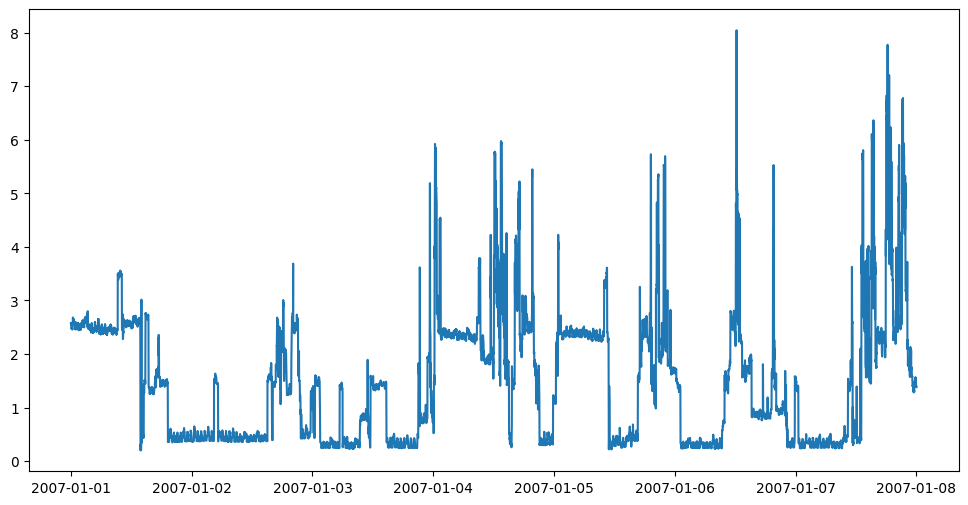

In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007.","mistral-saba-24b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Assuming df is already loaded and preprocessed as described
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for the first week of January 2007
first_week_jan_2007 = df['2007-01-01':'2007-01-07']
# Aggregate data by day
daily_usage = first_week_jan_2007.resample('D').sum()
# Plot the energy usage trend
plt.figure(figsize=(10, 6))
plt.plot(daily_usage.index, daily_usage['Global_active_power'], marker='o')
------------------------------------------------------------------------
Output of the code is:



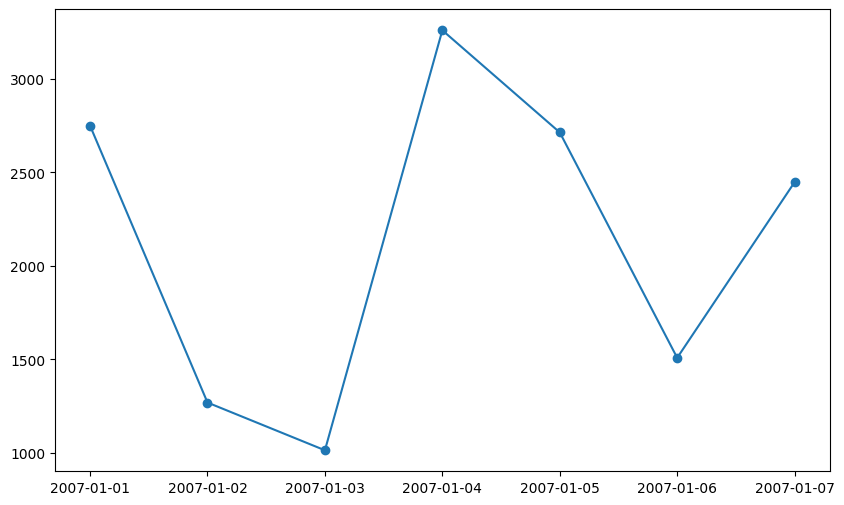

In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day","mistral-saba-24b",df)

In [ ]:
execute_query("What is the correlation between global active power and sub-metering values?.","mistral-saba-24b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Assuming the DataFrame `df` is already loaded and preprocessed as described
# Calculate the correlation matrix
correlation_matrix = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Print the correlation matrix
print(correlation_matrix)
------------------------------------------------------------------------
Output of the code is:

                     Global_active_power  Sub_metering_1  Sub_metering_2  \
Global_active_power             1.000000        0.484401        0.434569   
Sub_metering_1                  0.484401        1.000000        0.054721   
Sub_metering_2                  0.434569        0.054721        1.000000   
Sub_metering_3                  0.638555        0.102571        0.080872   

                     Sub_metering_3  
Global_active_power        0.638555  
Sub_metering_1             0.102571  
Sub_meteri

In [ ]:
execute_query("What is the correlation between global active power and sub-metering values?","gemma2-9b-it",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
df.corr()['Global_active_power']
------------------------------------------------------------------------
Output of the code is:



------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming df is already loaded and preprocessed as described
# df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['?'], low_memory=False)
# df = df.dropna()
# df['Global_active_power'] = df['Global_active_power'].astype(float)
# df = df.set_index('datetime')
# Calculate the correlation matrix
correlation_matrix = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Print the correlation matrix
print(correlation_matrix)
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
------------------------------------------------------------------------
Output of the code is:

                    

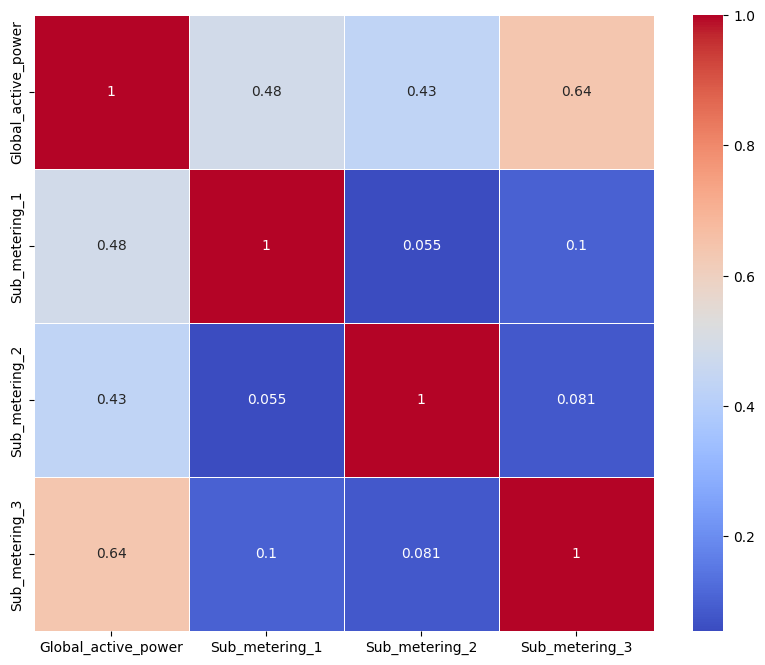

In [ ]:
execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization","mistral-saba-24b",df)

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2008","mistral-saba-24b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Assuming the DataFrame is already loaded as 'df'
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter the data for the first week of February 2008
first_week_feb_2008 = df['2008-02-01':'2008-02-07']
# Group by day and calculate the average voltage
average_voltage_per_day = first_week_feb_2008.resample('D')['Voltage'].mean()
print(average_voltage_per_day)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


datetime
2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Freq: D, Name: Voltage, dtype: float64
